In [71]:
import sys
import math
import re
import matplotlib.pyplot as plt



interval = "1ms"
output_dir = f"./exp/fattree/interval/{interval}"
sending_rate_file = f"{output_dir}/sending-rate.txt"
pfc_file = f"{output_dir}/pfc.txt"

start_time = 2000000000

def extract_numer(exp):
    res = re.findall(r"\d", exp)
    res = "".join([str(e) for e in res])
    return res

In [72]:
import sys
import math


sending_rate = {} # {node_id: {qp: {port: {time: rate}}}}
qpkey_to_id = {}
with open(sending_rate_file) as srf:
    for i, line in enumerate(srf):
        line_str = line.split()
        # print(line_str)
        ts = int(line_str[0]) - start_time
        node_id = int(line_str[1])
        qp_key = int(line_str[2])
        port = int(line_str[3])
        rate = float(line_str[4]) / float(1000000000);
        
        if node_id not in qpkey_to_id:
            qpkey_to_id[node_id] = {}
        if qp_key not in qpkey_to_id[node_id]:
            idx = len(qpkey_to_id[node_id])
            qpkey_to_id[node_id][qp_key] = idx
        qp_key = qpkey_to_id[node_id][qp_key]
        
        if node_id not in sending_rate:
            sending_rate[node_id] = {}
        if qp_key not in sending_rate[node_id]:
            sending_rate[node_id][qp_key] = {}
        if port not in sending_rate[node_id][qp_key]:
            sending_rate[node_id][qp_key][port] = {}
        sending_rate[node_id][qp_key][port][ts] = rate        
        
# for node_id in sending_rate:
#     for qp_key in sending_rate[node_id]:
#         for ts in sending_rate[node_id][qp_key]:
#             print(sending_rate[node_id][qp_key][ts])
            
# print(sending_rate)
        

In [73]:
"""parse pause and resume"""
pfc = {} # {node_id: {port: {ts: pause/resume}}}
with open(pfc_file) as pfcf:
    for i, line in enumerate(pfcf):
        line_str = line.split()
        ts = int(extract_numer(line_str[1])) - start_time
        node_id = int(extract_numer(line_str[3]))
        port = int(extract_numer(line_str[7]))
        pfc_type = int(extract_numer(line_str[9]))
        # print(ts, node_id, port, pfc_type)
        if node_id not in pfc:
            pfc[node_id] = {}
        if port not in pfc[node_id]:
            pfc[node_id][port] = {}
        pfc[node_id][port][ts] = pfc_type
print(pfc)        
        

{3: {1: {2833: 1, 7315: 0, 9065: 1, 12800: 0, 14633: 1, 18119: 0, 633434: 1, 635524: 0, 1003942: 1, 1313969: 0, 1315470: 1, 1598244: 0, 1601246: 1, 1917130: 0, 1918631: 1, 2010754: 0, 3004289: 1, 3314049: 0, 3315550: 1, 3581641: 0, 3584643: 1, 3900278: 0, 3901779: 1, 4010253: 0, 5004363: 1, 5304984: 0, 5307903: 1, 5614989: 0, 5616490: 1, 5857930: 0, 5902784: 1, 6010235: 0, 7004530: 1, 7296530: 0, 7299449: 1, 7606535: 0, 7608036: 1, 7849559: 0, 7911179: 1, 8001698: 0, 9004598: 1, 9296467: 0, 9299469: 1, 9598338: 0, 9599839: 1, 9841279: 0, 9953114: 1, 10010101: 0, 11004926: 1, 11296378: 0, 11299297: 1, 11589866: 0, 11591367: 1, 11799607: 0, 11944725: 1, 12010261: 0, 13005146: 1, 13296100: 0, 13298936: 1, 13548088: 0, 13559078: 1, 13849295: 0, 13911164: 1, 14009402: 0, 15005181: 1, 15279779: 0, 15282532: 1, 15705984: 0, 15710002: 1, 15800853: 0, 15919577: 1, 15951581: 0, 17005446: 1, 17271237: 0, 17274073: 1, 17431759: 0, 17450136: 1, 17715702: 0, 17717203: 1, 17774964: 0, 17886052: 1, 17

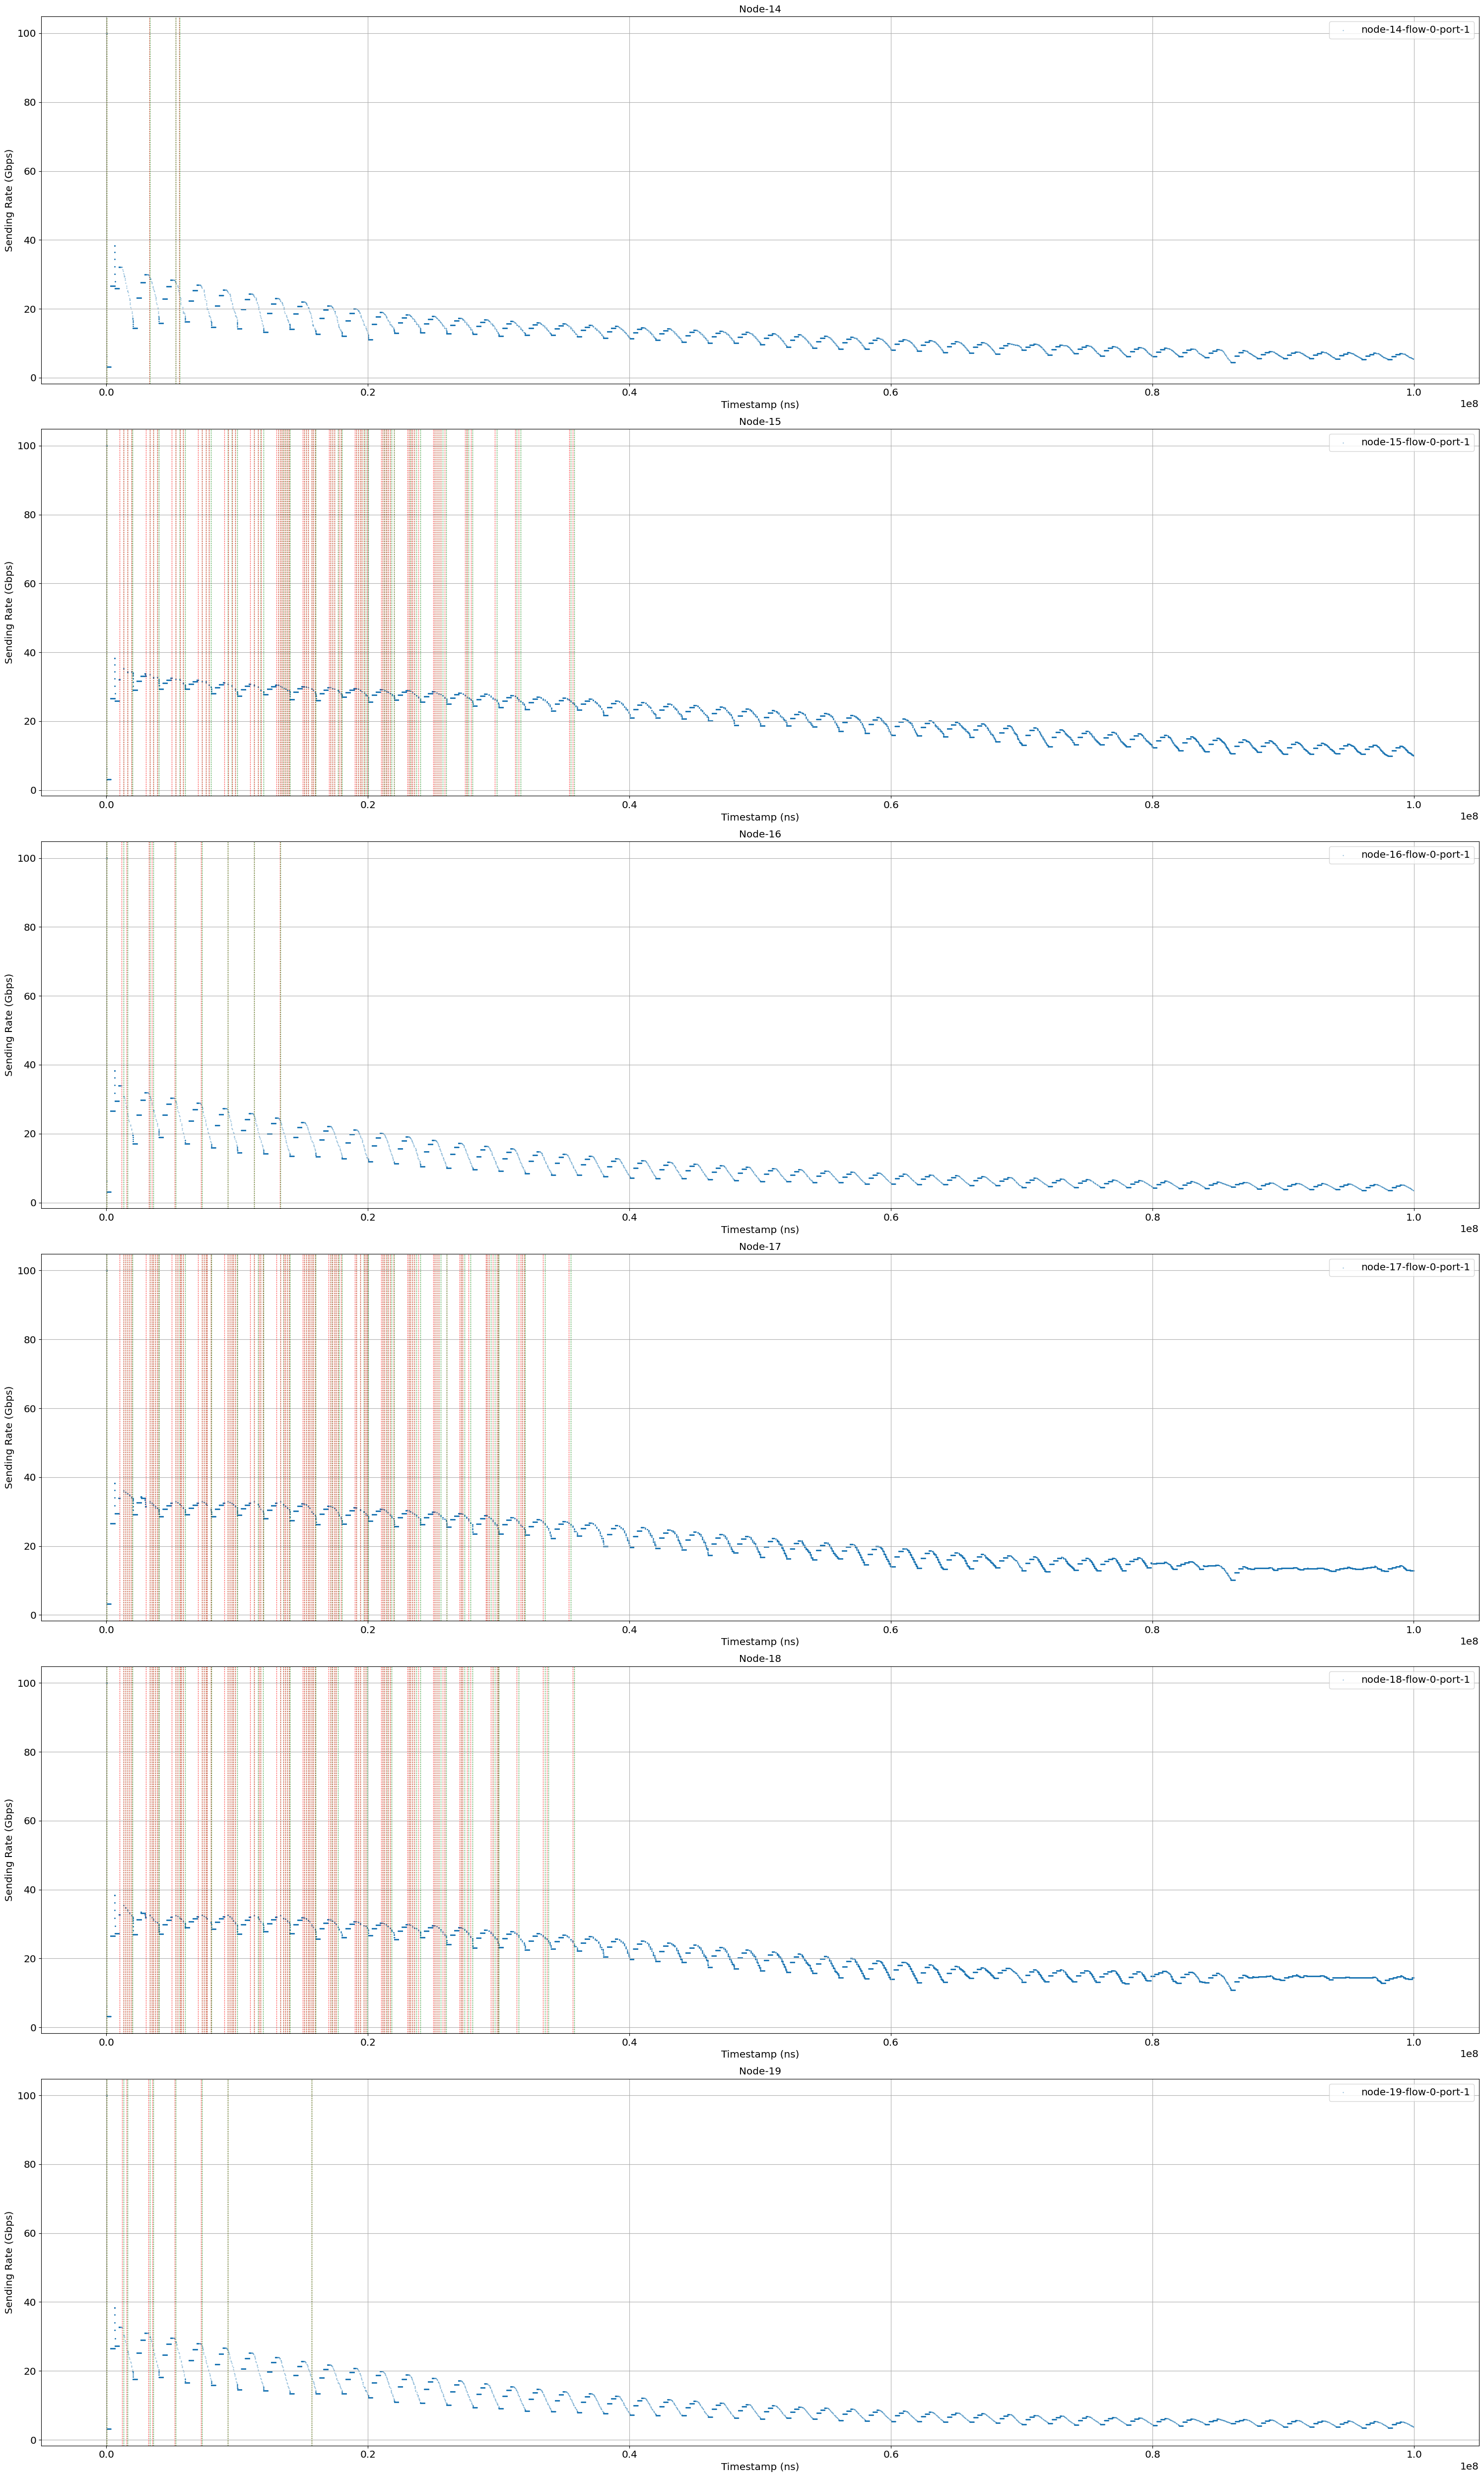

In [74]:
# sending rate
nodes_to_plot = [14, 15, 16, 17, 18, 19]
fig, ax = plt.subplots(len(nodes_to_plot), figsize=(30, 50))

for idx, node_id in enumerate(sending_rate.keys()):
    if node_id not in nodes_to_plot:
        continue
    for qp_key in sending_rate[node_id]:
        assert(len(sending_rate[node_id][qp_key])) == 1
        port = 1
        x = list(sending_rate[node_id][qp_key][port].keys())
        y = list(sending_rate[node_id][qp_key][port].values())
        x = [tx for tx, rate in sending_rate[node_id][qp_key][port].items() if tx <= 1e8]
        y = [rate for tx, rate in sending_rate[node_id][qp_key][port].items() if tx <= 1e8]

        num_pts = math.inf
        num_pts = min(num_pts, len(x))
        x = x[:num_pts]
        y = y[:num_pts]
        ax[idx].scatter(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}", s=0.1) 

        
        if node_id in pfc and port in pfc[node_id]:
            pfc_node_port = pfc[node_id][port]
            for tx, pause_resume in pfc[node_id][port].items():
                # print(tx, "pause" if pause_resume==1 else "resume")
                ax[idx].axvline(x=tx, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)
                    
                    
        ax[idx].set_title(f'Node-{node_id}')
        ax[idx].set_xlabel("Timestamp (ns)")
        ax[idx].set_ylabel("Sending Rate (Gbps)")
        ax[idx].grid()
        ax[idx].legend()
            
            


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# plt.grid()
plt.tight_layout()
# plt.legend() 
# plt.show()
plt.savefig(f"{output_dir}/send_rate.png")

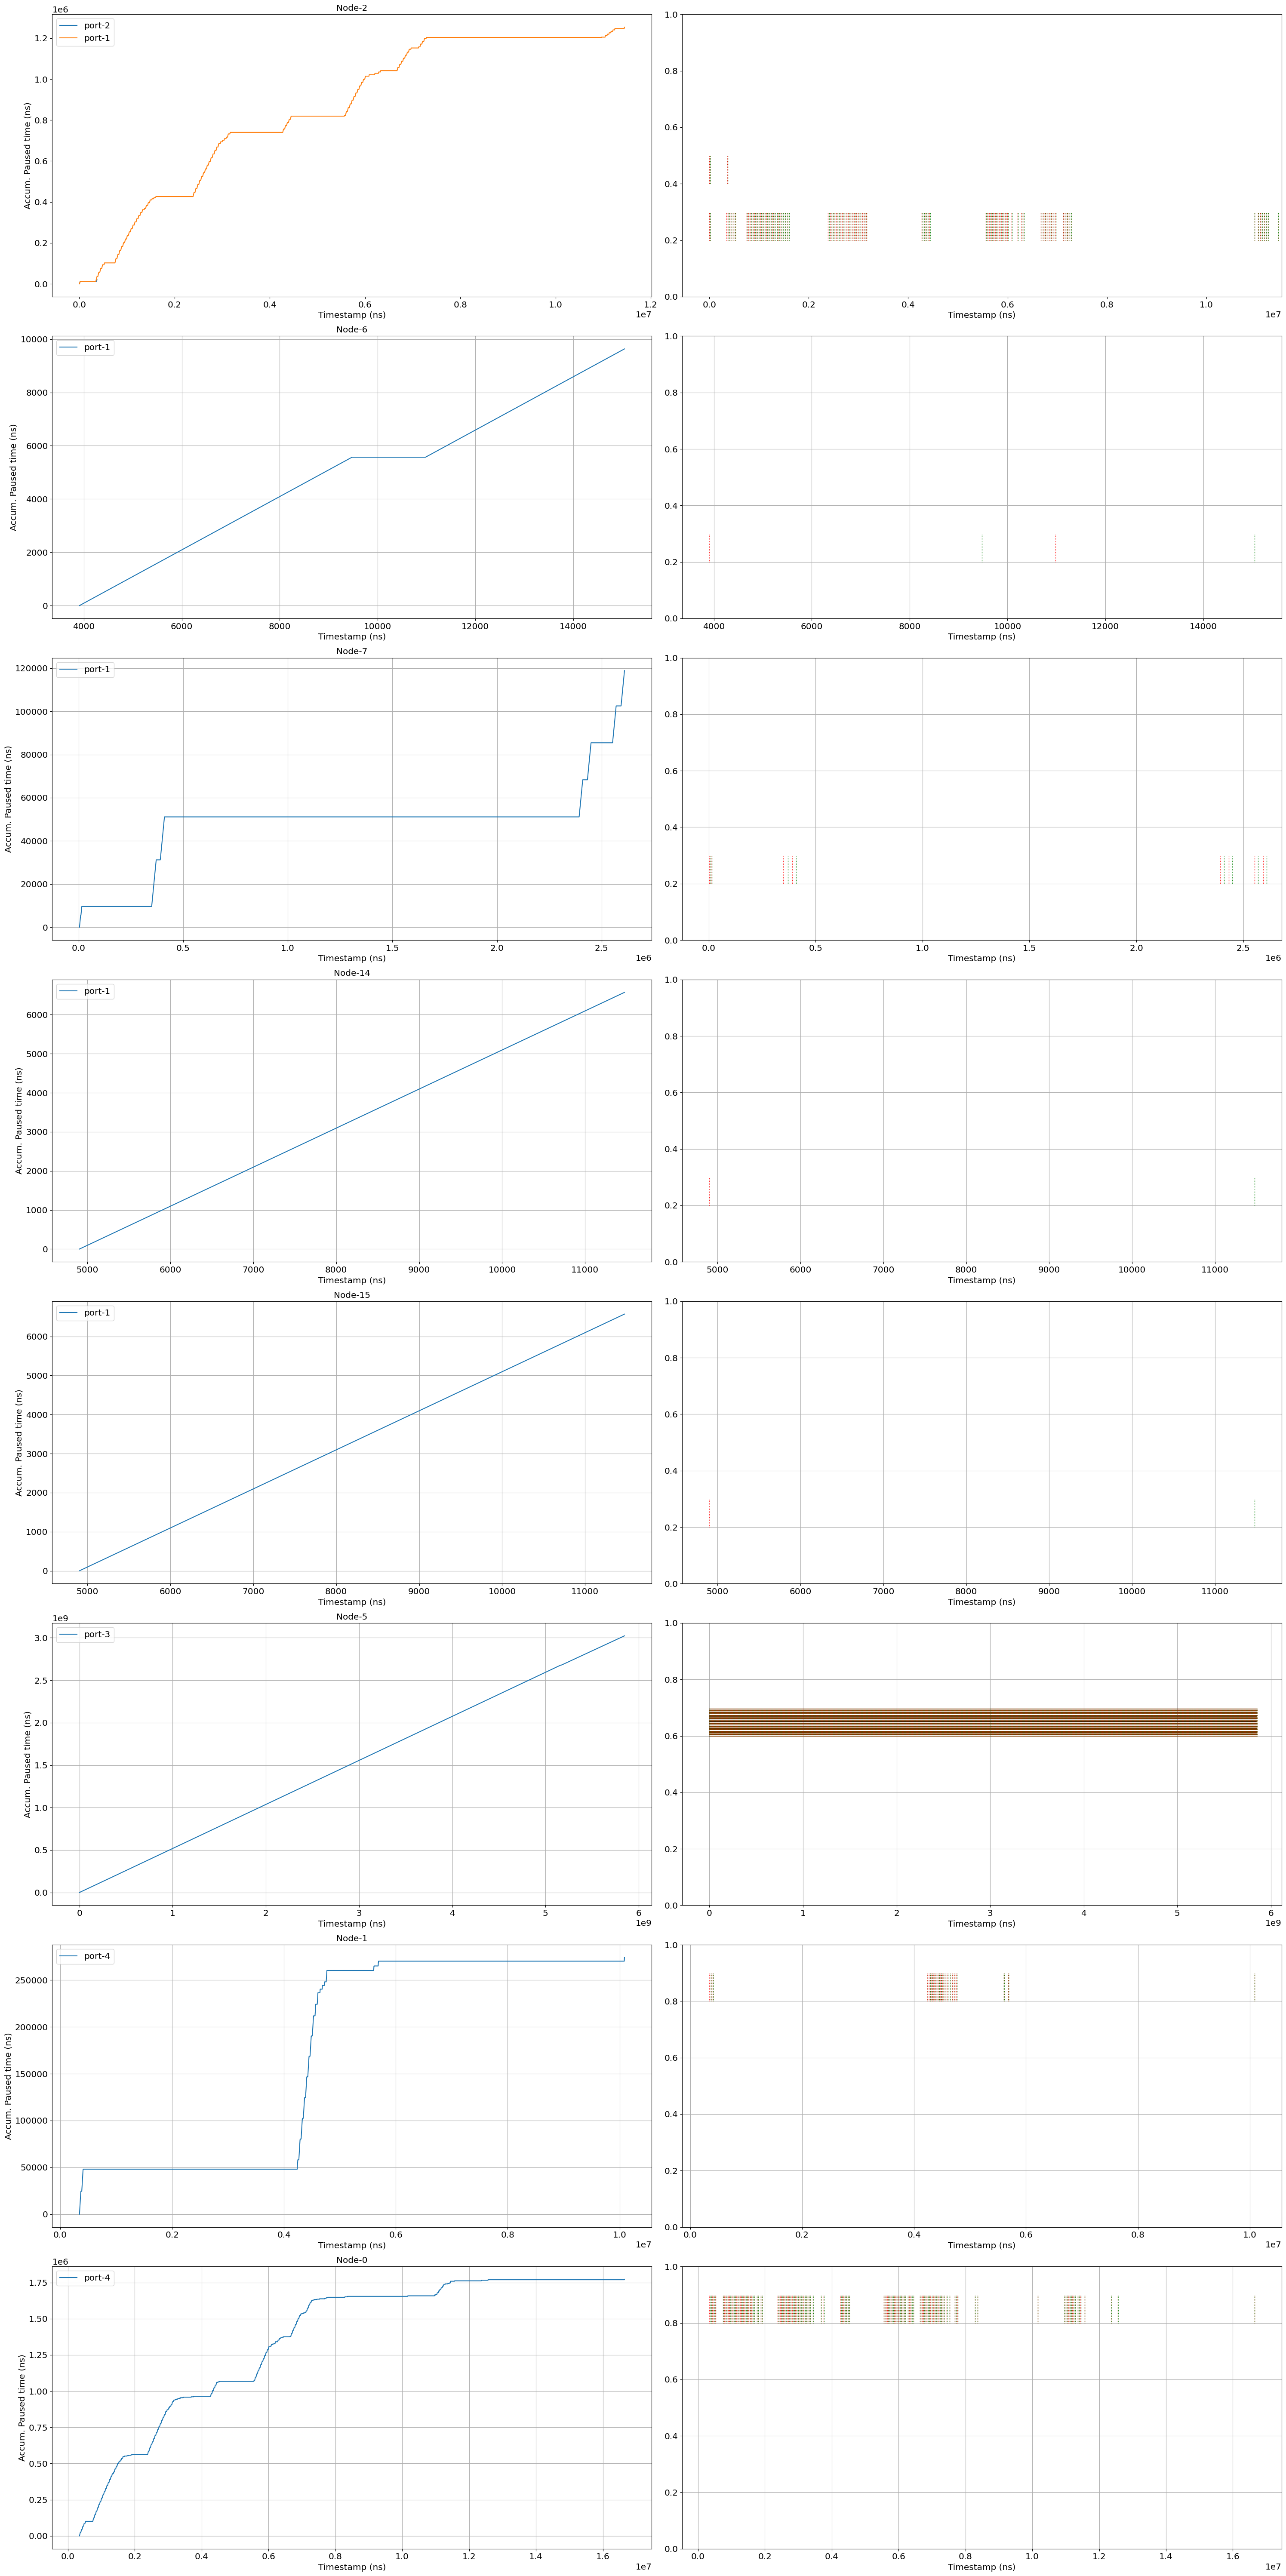

In [68]:
# accumulated pause time

# check PFC at each node, not just senders
accumulated_pause_time = {}

for node_id in pfc:
    if node_id not in [0,1,2,5,6,7,14,15]:
        continue
    accumulated_pause_time[node_id] = {}
    for port in pfc[node_id]:
        accumulated_pause_time[node_id][port] = {}
        accum = 0
        last_pause = 0
        for tx, pause_resume in pfc[node_id][port].items():
            if pause_resume == 1:
                accumulated_pause_time[node_id][port][tx] = accum
                last_pause = tx
            else:
                accum += (tx - last_pause)
                accumulated_pause_time[node_id][port][tx] = accum

fig, ax = plt.subplots(len(accumulated_pause_time), 2, figsize=(30, 60))

for idx, node_id in enumerate(accumulated_pause_time.keys()):
    
    for port in accumulated_pause_time[node_id]:
        x = list(accumulated_pause_time[node_id][port].keys())
        y = list(accumulated_pause_time[node_id][port].values())
        ax[idx,0].plot(x, y, label=f"port-{port}")
        ax[idx,0].set_title(f'Node-{node_id}')
        ax[idx,0].set_xlabel("Timestamp (ns)")
        ax[idx,0].set_ylabel("Accum. Paused time (ns)")
        ax[idx,0].grid()
        ax[idx,0].legend()
        # ax[idx,0].setsize
        
        for tx, pause_resume in pfc[node_id][port].items():
            ax[idx,1].axvline(x=tx, ymin=0.2*port, ymax=0.2*port+0.1, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)
        ax[idx,1].set_xlabel("Timestamp (ns)")
        # ax[idx,1].set_ylabel("Accum. Paused time (ns)")
        ax[idx,1].grid()
        # ax[idx,0].legend()
        
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# plt.grid()
plt.tight_layout()
# plt.legend() 
# plt.show()
plt.savefig(f"{output_dir}/pfc.png")

In [ ]:
print(pfc[12])